In [1]:
import matplotlib.pyplot as plt
from optiland.analysis.irradiance import IncoherentIrradiance
from optiland.samples.simple import AsphericSinglet
from optiland.physical_apertures.rectangular import RectangularAperture
from optiland.optic import Optic

In [2]:
lens = AsphericSinglet()
# we have a bug here - after we define the physical aperture, the system until the image plane is no longer
# shown
im_surf = lens.surface_group.surfaces[-1]
im_surf.aperture = RectangularAperture(x_min=-1, x_max=1, y_min=-1, y_max=1)

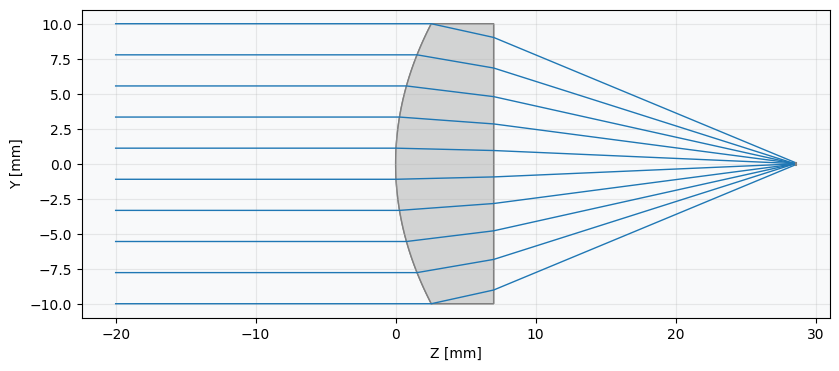

In [3]:
lens.draw(num_rays=10)

In [4]:
lens.info()

╒════╤═════════════════════╤═══════════╤══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type                │ Comment   │   Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪═════════════════════╪═══════════╪══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar              │           │      inf │     inf     │ Air        │       0 │    10           │
│  1 │ Stop - Even Asphere │           │       20 │       7     │ N-SF11     │       0 │    10           │
│  2 │ Planar              │           │      inf │      21.562 │ Air        │       0 │     8.461       │
│  3 │ Planar              │           │      inf │     nan     │ Air        │       0 │     1.02419e-09 │
╘════╧═════════════════════╧═══════════╧══════════╧═════════════╧════════════╧═════════╧═════════════════╛


In [5]:
irradiance = IncoherentIrradiance(lens, n_rays=100, detector_surface=-1)

In [6]:
from optiland.rays import RealRays
import optiland.backend as be
import matplotlib.pyplot as plt
import numpy as np

[[-2.25 -1.25 -0.25  0.75  1.75]
 [-2.25 -1.25 -0.25  0.75  1.75]
 [-2.25 -1.25 -0.25  0.75  1.75]
 [-2.25 -1.25 -0.25  0.75  1.75]
 [-2.25 -1.25 -0.25  0.75  1.75]] (5, 5)
[[-2.25 -2.25 -2.25 -2.25 -2.25]
 [-1.25 -1.25 -1.25 -1.25 -1.25]
 [-0.25 -0.25 -0.25 -0.25 -0.25]
 [ 0.75  0.75  0.75  0.75  0.75]
 [ 1.75  1.75  1.75  1.75  1.75]]


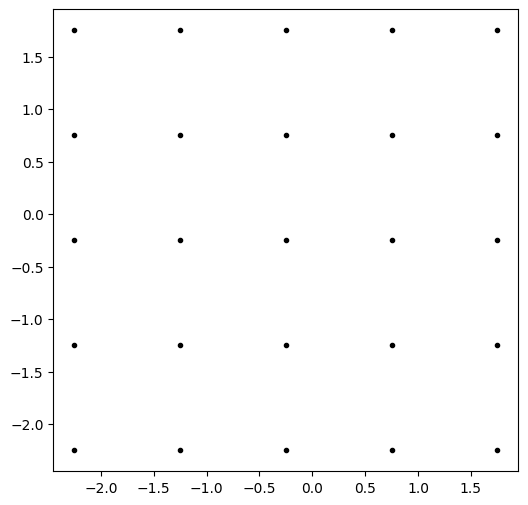

In [7]:
# test unit 1 - square grid of rays
x_rays = be.linspace(-2.25, 1.75, 5)
x, y = be.meshgrid(x_rays, x_rays)
print(x, x.shape)
print(y)
plt.figure(figsize=(6,6))
plt.plot(x,y, marker='.', color='k', linestyle='none')
plt.show()

In [ ]:
# now create the rays to be launched 
L = np.zeros((x.shape[0]**2), dtype='float64')
M = L
N = np.ones(x.shape[0]**2, dtype='float64')
I = np.ones(x.shape[0]**2, dtype='float64')
W = np.full(x.shape[0]**2, 0.55)
test_rays = RealRays(x, y, be.zeros(x.shape[0]**2), L, M, N, I, W)

print(test_rays.x)

[-2.25 -1.25 -0.25  0.75  1.75 -2.25 -1.25 -0.25  0.75  1.75 -2.25 -1.25
 -0.25  0.75  1.75 -2.25 -1.25 -0.25  0.75  1.75 -2.25 -1.25 -0.25  0.75
  1.75]


In [9]:
# now we can define our test system
class TestSystemIrradianceV1(Optic):
    def __init__(self):
        super().__init__()
        
        self.add_surface(index=0, thickness=be.inf)
        self.add_surface(index=1, thickness=0, is_stop=True)
        self.add_surface(index=2, thickness=10) 
        self.add_surface(index=3) # image 
        
        # add a physical aperture to the image plane (the sensor)
        detector_size = RectangularAperture(x_max=2.5, x_min=-2.5, y_max=2.5, y_min=-2.5)
        self.surface_group.surfaces[-1].aperture = detector_size
        
        
        self.add_wavelength(0.55)
        self.set_field_type('angle')
        self.add_field(y=0)
        self.set_aperture('EPD',5.0)
        
        

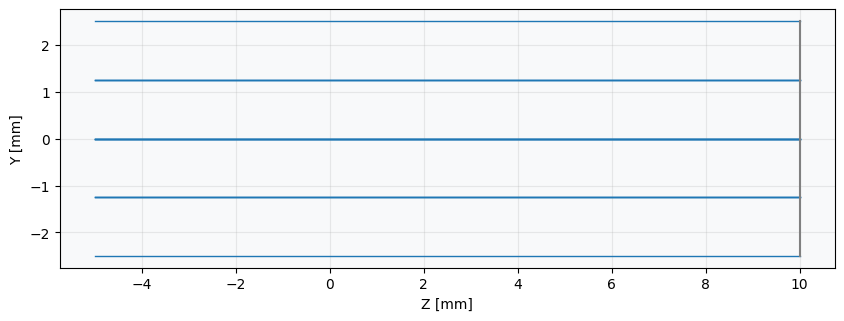

In [10]:
optic = TestSystemIrradianceV1()
optic.draw(distribution='uniform', num_rays=5)
#optic.draw3D(distribution='uniform', num_rays=5 )

In [11]:
# we can now test the irradiance calculation. 
# we should get exactly 1 ray per pixel in the given conditions
irr = IncoherentIrradiance(optic, n_rays=5, distribution='uniform', res=(5,5))

In [12]:
print(irr.irr_data)

[[(array([[0., 0., 1., 0., 0.],
       [0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0.]]), array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5]), array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5]))]]


In [13]:
irr_user = IncoherentIrradiance(optic, res=(5,5), user_initial_rays=test_rays)

In [14]:
print(irr_user.irr_data)

[[(array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]]), array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5]), array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5]))]]


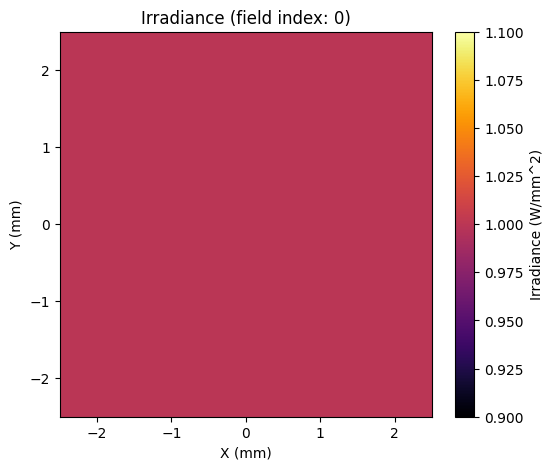

In [15]:
irr_user.view()

[[(array([[4., 0., 4., 0., 4., 0., 4., 0., 4., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 4., 0., 4., 0., 4., 0., 4., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 4., 0., 4., 0., 4., 0., 4., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 4., 0., 4., 0., 4., 0., 4., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 4., 0., 4., 0., 4., 0., 4., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]), array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]))]]


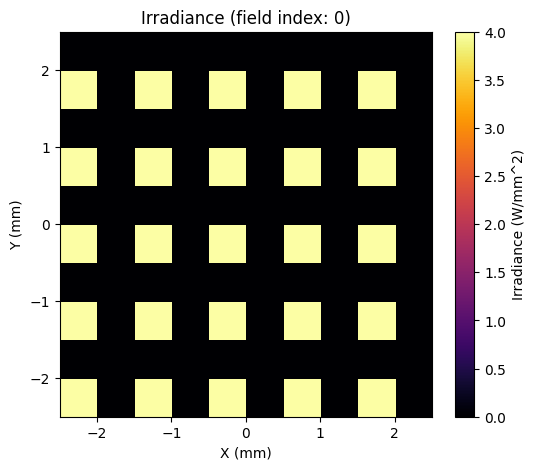

In [16]:
irr_user = IncoherentIrradiance(optic, res=(10,10), user_initial_rays=test_rays)
print(irr_user.irr_data)
irr_user.view()

Now we want to apply a gaussian apodization and check the result

In [17]:
def apply_gaussian_apodization(x_coords_flat, y_coords_flat, sigma_x, sigma_y, peak_intensity=1.0):
    exponent = -(((x_coords_flat**2) / (2 * sigma_x**2)) + ((y_coords_flat**2) / (2 * sigma_y**2)))
    intensities = peak_intensity * np.exp(exponent)
    return intensities

In [31]:
# now create the rays to be launched 
x_rays = be.linspace(-2.5, 2.5, 526)
x, y = be.meshgrid(x_rays, x_rays)
L = np.zeros((x.shape[0]**2), dtype='float64')
M = L
N = np.ones(x.shape[0]**2, dtype='float64')
I = np.ones(x.shape[0]**2, dtype='float64')
W = np.full(x.shape[0]**2, 0.55)

x_flat = x.flatten()
y_flat = y.flatten()

gaussian_intensities = be.array(apply_gaussian_apodization(x_flat, y_flat, sigma_x=0.5, sigma_y=0.5))

In [32]:
# test apodized rays
test_apodized_rays = RealRays(x, y, be.zeros(x.shape[0]**2), L, M, N, gaussian_intensities, W)

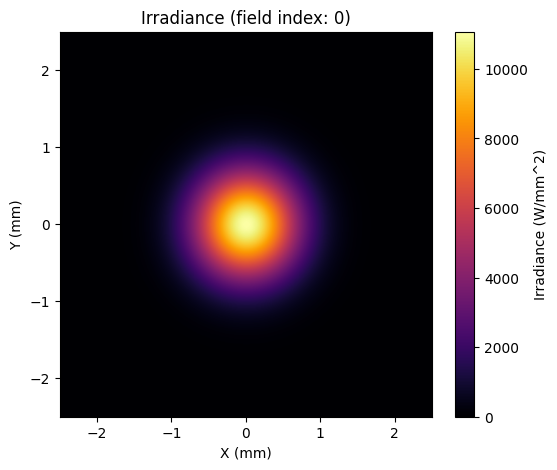

In [36]:
irr_user_apod = IncoherentIrradiance(optic, res=(526,526), user_initial_rays=test_apodized_rays)
#print(irr_user_apod.irr_data)
irr_user_apod.view()

Now we can finally test the irradiance detector for simple parabolic mirror, that reflects an incoming parallel ray bundle to a single point in the image plane. 